## Информация о проекте:

- Приложение с пробным периодном 7 дней с дальнейшим переходом в оплату 4.99 USD в неделю
- Каждая строка -- отдельное событие
- Стоимость привлечения одного пользователя 6 USD

## Открытие файлов

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np


import warnings
warnings.filterwarnings("ignore")

In [2]:
data=pd.read_excel('/Users/irinasaahmetova/Downloads/test case data analyst.xlsx')

In [3]:
data.head()

,product_id,quantity,is_trial_period,purchase_date,user_id
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657


## Предобработка данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114200 entries, 0 to 114199
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   product_id       114200 non-null  object        
 1   quantity         114200 non-null  int64         
 2   is_trial_period  114200 non-null  bool          
 3   purchase_date    114200 non-null  datetime64[ns]
 4   user_id          114200 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(1)
memory usage: 3.6+ MB


В данных нет пропусков, все столбцы приведены к нужному типу

In [5]:
# Проверим на наличие дубликатов
data.duplicated().sum()

84

In [6]:
# Удалим дубликаты
data = data.drop_duplicates().reset_index(drop=True)

Проверим столбцы product_id и quantity:

In [7]:
data['product_id'].unique()

array(['1week_4.99_USD_subscription_7days_trial'], dtype=object)

In [8]:
data['quantity'].unique()

array([1])

В этих столбцах повторяется одно значение, чтобы они нам не мешались, удалим их

In [9]:
data = data.drop(columns = ['product_id', 'quantity'])

Найдем максимальное и минимальное значения, чтобы выяснить, за какой период представлены данные

In [10]:
data['purchase_date'].min()

Timestamp('2020-01-01 00:00:00')

In [11]:
data['purchase_date'].max()

Timestamp('2020-02-20 00:00:00')

**Вывод:**

   В датасете представлены данные об оплатах приложения с 1 января по 20 февраля 2020 года. 
   
**Информация**
 - is_trial_period -- является ли данное действие подключением пробного периода(бесплатное действие) или это уже оплата подписки
 - purchase_date -- дата совершенного действия
 - user_id - идентификационный номер пользователя

##  Добавление необходимых значений в таблицу

**Добавим информацию о стоимости подписки(4.99 USD) и о стоимости привличения клиента(6USD):**

In [12]:
data['revenue'] = 4.99
data['acquisition_cost'] = 6

**Найдем дату первой покупки каждого пользователя:**

In [13]:
# Находим дату первой покупки

first_ts = (
    data.sort_values(by=['user_id', 'purchase_date'])
    .groupby('user_id')
    .agg({'purchase_date' : 'first'})
    .rename(columns={'purchase_date': 'first_ts'})
    .reset_index()
)

# Прикрепим ее к датасету
data = data.merge(first_ts, on = 'user_id')

Так как оплата подписки происходит каждую неделю, добавим столбцы с **неделей оплаты** и с **неделей первой покупки**

In [14]:
data['purchase_date_week'] = data['purchase_date'].dt.isocalendar().week
data['first_ts_week'] = data['first_ts'].dt.isocalendar().week

**Добавим лайфтайм пользователя для каждой покупки**

In [15]:
# Добавим лайфтайм по дням
data['lifetime'] = data['purchase_date'] - data['first_ts']

# Лайфтайм по неделям
data['lifetime_week'] = data['purchase_date_week'] - data['first_ts_week']

In [16]:
data.head()

,is_trial_period,purchase_date,user_id,revenue,acquisition_cost,first_ts,purchase_date_week,first_ts_week,lifetime,lifetime_week
0,False,2020-02-19,9484222,4.99,6,2020-02-12,8,7,7 days,1
1,True,2020-02-12,9484222,4.99,6,2020-02-12,7,7,0 days,0
2,False,2020-02-17,9422402,4.99,6,2020-02-10,8,7,7 days,1
3,True,2020-02-10,9422402,4.99,6,2020-02-10,7,7,0 days,0
4,False,2020-02-18,4997991,4.99,6,2020-02-11,8,7,7 days,1


**Добавим столбец dt, в котором будет храниться дата первого посещение в формате date:**

In [17]:
data['dt'] = data['first_ts'].dt.date

**Добавим информацию о том, что если это подключение пробного периода, то стоимость будет 0 USD:***

In [18]:
data = data.assign(mapped=data.is_trial_period.map({True: 'yes', False: 'no'}))

data.loc[data['mapped'] == 'yes', 'revenue'] = 0

## Таблица удержания

In [19]:
# Формула для нахождения удержания по дням/неделям
def get_retention(data, index):
    
    # Строим таблицу удержания пользователей
    retention = data.pivot_table(
        index = index, columns = 'lifetime_week', values = 'user_id', aggfunc='nunique'
    )
    
    # Добавляем размер кагорт
    cohort_sizes = (
        data.groupby(index)
        .agg({'user_id' : 'nunique'})
        .rename(columns={'user_id' : 'cohort_size'})
    )
    
    retention = cohort_sizes.merge(
        retention, on=index, how='left'
    ).fillna(0)
    
    
    # Находим долю пользователей, "доживших" до лайфтайма
    retention = retention.div(
        retention['cohort_size'], axis=0
    ).drop(columns=['cohort_size'])
    
    return retention

In [20]:
# Таблица удержания с кагортами, распределенными по дню первой покупки
retention_by_days = get_retention(data, 'dt')


<AxesSubplot:ylabel='dt'>

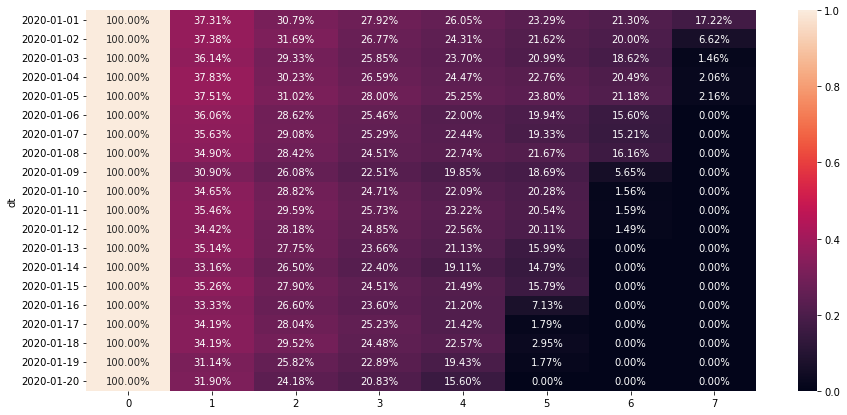

In [21]:
plt.figure(figsize = (15,7))
sns.heatmap(retention_by_days.head(20), annot=True, fmt='.2%')

In [22]:
# Найдем удержания с кагортами по неделе регистрации

retention_by_week = get_retention(data, 'first_ts_week')

<AxesSubplot:ylabel='first_ts_week'>

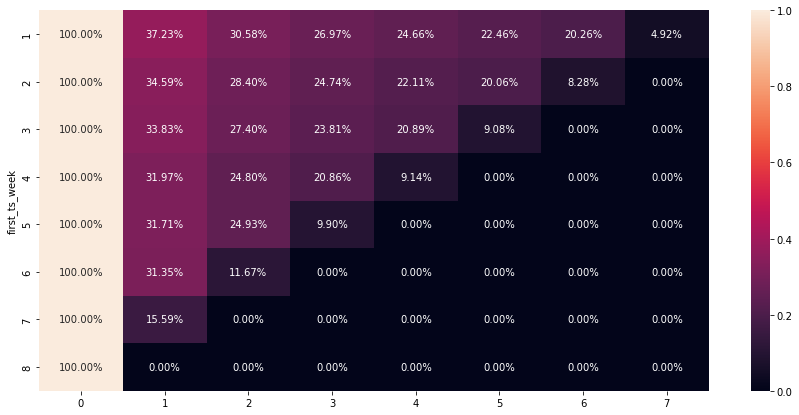

In [23]:
plt.figure(figsize = (15,7))
sns.heatmap(retention_by_week, annot=True, fmt='.2%')

**Вывод:**

 - Полный цикл в 7 недель "прожили" только 5 кагорт: оформившие пробный период 1-5 января.
 - Удержание пользователей после окончания пробного периода падает каждую неделю: 37.23% в первую неделю января и 15.59% к 3 неделе февраля
 - Для расчета LTV я буду брать за горизонт анализа 4 недели, так как примерно половина пользователей в данных прожили этот период.

## Расчет текущего LTV и ROMI

In [24]:
# Расчет LTV и ROMI

def get_ltv(
    data,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
    
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    #if not ignore_horizon:
    last_suitable_acquisition_date = observation_date - timedelta(
        days=horizon_days - 1
    )
    result_raw = data.query('first_ts <= @last_suitable_acquisition_date')

    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['purchase_date'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROMI: делим LTV на CAC
        romi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROMI
        romi = romi[~romi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROMI
        romi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROMI
        romi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROMI в лайфтаймы, не превышающие горизонт анализа
        romi = romi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROMI
        return result, romi

    # получаем таблицы LTV и ROMI
    result_grouped, romi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROMI
    result_in_time, romi_in_time = group_by_dimensions(
        result_raw, dimensions + ['first_ts'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        romi_grouped,  # таблица ROMI
        romi_in_time,  # таблица динамики ROMI
    ) 

In [25]:
# Функция для сглаживания фрейма

def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [26]:
# функция для визуализации LTV и ROMI

def plot_ltv_romi(ltv, ltv_history, romi, romi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    # стоимость привлечения запишем в отдельный фрейм
    cac_history = romi_history[['cac']]

    # из таблицы romi исключаем размеры когорт и cac
    romi = romi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики romi оставляем только нужный лайфтайм
    romi_history = romi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['first_ts']]
    filtered_data = ltv_history.pivot_table(
        index='first_ts', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filtered_data.plot(grid=True, ax=ax2)   #(filtered_data, window)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['first_ts']]
    filtered_data = cac_history.pivot_table(
        index='first_ts', columns=columns, values='cac', aggfunc='mean'
    )
    filtered_data.plot(grid=True, ax=ax3)    #(filtered_data, window)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые romi
    ax4 = plt.subplot(2, 3, 4)
    romi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROMI')

    # пятый график — динамика romi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in romi_history.index.names if name not in ['first_ts']]
    filtered_data = romi_history.pivot_table(
        index='first_ts', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filtered_data.plot(grid=True, ax=ax5)    #(filtered_data, window)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROMI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [27]:
# Устанавливаем горизонт анализа 4 недели - 28 дней
horizon_days = 28

In [28]:
ltv_raw, ltv, ltv_history, romi, romi_history = get_ltv(data, data['purchase_date'].max(), horizon_days)

<AxesSubplot:ylabel='cohort'>

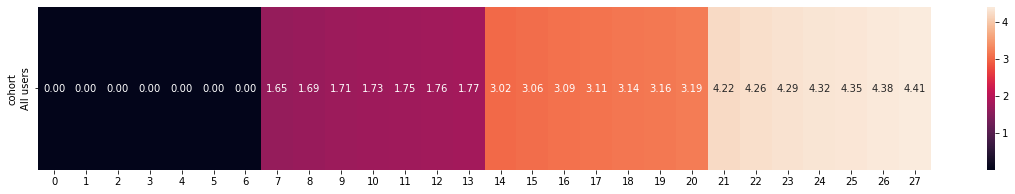

In [29]:
plt.figure(figsize=(20,3))
sns.heatmap(ltv.drop(columns=['cohort_size']), annot=True, fmt='.2f')

LTV пользователей, впервые воспользавшихся приложением в январе 2020 года, составляет в среднем 4.41 долларов к окончанию 4 недели пользования.

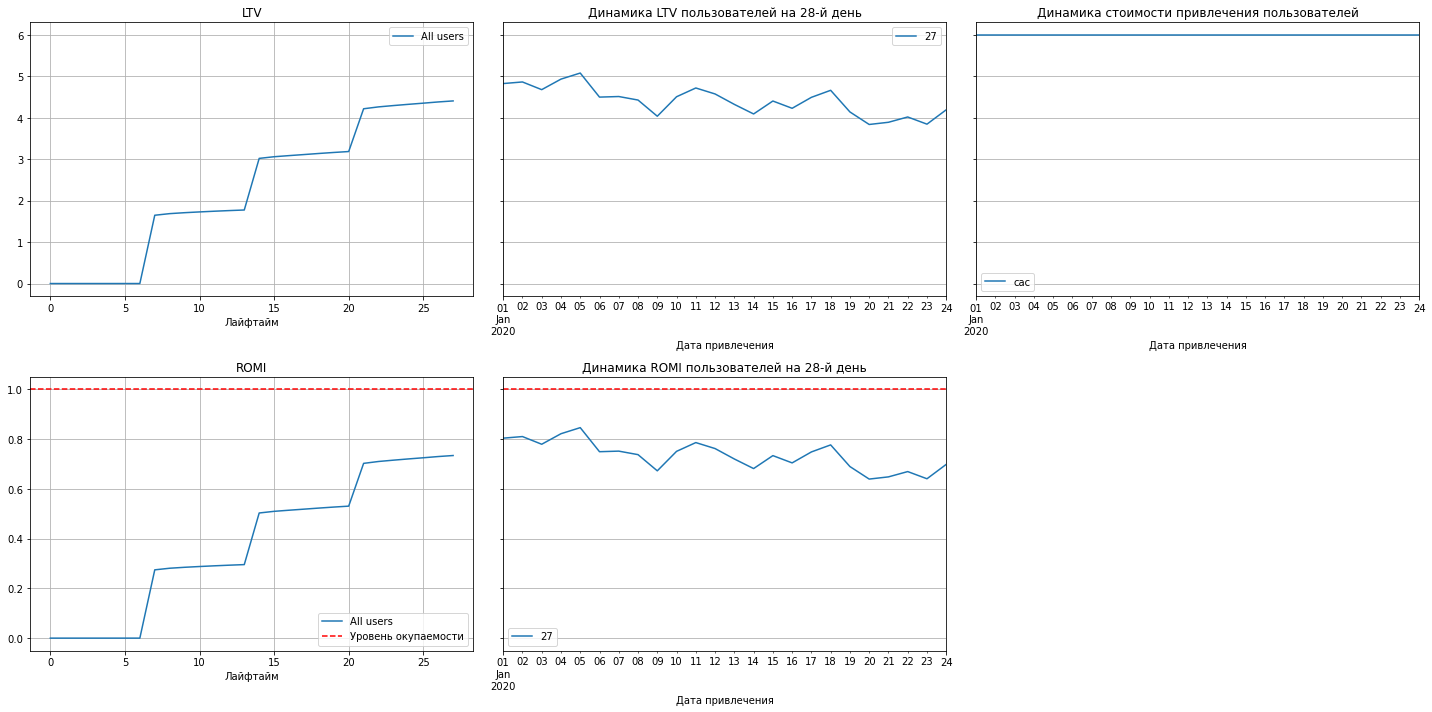

In [30]:
plot_ltv_romi(ltv, ltv_history, romi, romi_history, horizon_days, window=7)

**Вывод:**

 - Канал привлечения пользователей не окупается к 4 неделе пользования приложением.
 - На графике заметны скачки LTV каждые 7 дней. Это обусловлено тем, что в приложении действует система еженедельного продления подписки.
 - LTV последнего дня цикла(4 недели) постоянно снижается, в то время как стоимость привлечения пользователей остается неизменной
 - Так как у нас нет информации о распределении пользователей по странам, девайсам или рекламным каналам(если их несколько), мы не можем выяснить, из-за каких конкретно групп привлечение пользователей не окупается. 
 -  Ввиду того что удержание пользователей снижается, многие из них не успевают прожить полный цикл, который приведет к окупаемости (примерно 5 недель). Удержание к 5 недели составляет 15-20%. Таким образом, достичь окупаемости можно только при увеличении процента удержания пользователей